# Deep Learning Approach for Classifying Chest X-rays
Notebook 1 of 4

**CONTEXT**

A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal and other lung infection dataset is released in stages. In the 2nd release, we have increased the database to:
- 3616 COVID-19 positive cases
- 10,192 Normal
- 6012 Lung Opacity (Non-COVID lung infection)
- 1345 Viral Pneumonia


**PERFORMANCE MEASURES**

We are interested in classifiying correctly as many #1) COVID, #2) Viral Pneumonia, and #3) Lung Opacity. <br>
As a result, our primary performance metric by class is **weighted sensitivity (recall)** because it summarizes how well the positive class was correclty predicted. <br>
Also, we'll look at **weighted accuracy** for the overall model performance as 3 out of 4 classes are relatively important to correctly classify.

# Setup

In [40]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb

# specify current working dir 
path_to_cwd = '/Sylvie_notebooks/DS4' 

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
The chime extension is already loaded. To reload it, use:
  %reload_ext chime
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------


In [41]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3578178017613354790
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6945177600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10339757555723940672
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [43]:
tf.test.is_built_with_cuda()

True

In [44]:
%%script False
gpus = tf.config.list_physical_devices('GPU')
if gpus:
   try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Couldn't find program: 'False'


In [45]:
%%script False
# Copy the entire GCS bucket to a local directory 
!gsutil -m cp -r gs://big_data_project_storage/* .

Couldn't find program: 'False'


# 1) Data Pre-Processing

## A) Data Integration

Note: <br>
- Dataset name: COVID-19 Radiography Dataset
- Dataset size: 780 MB
- Dataset includes 1 metadata.csv file and 21.2k images files

Let's start by reading the metadata file to get familiarize with the features.

### Load metadata

In [46]:
# Call function to get metedata file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json"
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) # get dataset directly from google cloud storage
metadata.head()

Unnamed: 0       file_name  \
0           0     COVID-1.png   
1           1    COVID-10.png   
2           2   COVID-100.png   
3           3  COVID-1000.png   
4           4  COVID-1001.png   

                                image_data_grayscale file_format image_shape  \
0  [[185  40   0 ...   0  24 131]\n [ 75  14   0 ...         PNG  (299, 299)   
1  [[135 133 131 ...  24  21  19]\n [132 130 129 ...         PNG  (299, 299)   
2  [[ 62  10   0 ... 197 200 209]\n [ 35   6   0 ...         PNG  (299, 299)   
3  [[162 162 162 ...   4   4   5]\n [ 26  26  26 ...         PNG  (299, 299)   
4  [[  0   0   0 ...   0   0   0]\n [  0   0   0 ...         PNG  (299, 299)   

   label  
0  COVID  
1  COVID  
2  COVID  
3  COVID  
4  COVID

### Load Images

**(i) Create a DF_Normal**

In [47]:
normal_df = load_data_into_df('Normal', path_to_cwd)
print(f'There are {len(normal_df)} images in the Normal Class')

There are 10192 images in the Normal Class


**(ii) Create a DF_Covid**

In [48]:
covid_df = load_data_into_df('COVID', path_to_cwd)
print(f'There are {len(covid_df)} images in the Covid Class')

There are 3616 images in the Covid Class


**(iii) Create a DF_LungOpacity**

In [49]:
opacity_df = load_data_into_df('Lung_Opacity', path_to_cwd)
print(f'There are {len(opacity_df)} images in the Lung_Opacity Class')

There are 6012 images in the Lung_Opacity Class


**(iv) Create a DF_Pneumonia**

In [50]:
pneumonia_df = load_data_into_df('Viral_Pneumonia', path_to_cwd)
print(f'There are {len(pneumonia_df)} images in the Viral Pneumonia Class')

There are 1345 images in the Viral Pneumonia Class


### Merge datasets
We should merge all datasets together to redistribute (stratify) the classes equality between training, validation, and test sets

In [51]:
# Total number of images in each DF
total = len(normal_df) + len(covid_df) + len(opacity_df) + len(pneumonia_df)
print(f'There are a total of {total} images if we combine all dataframes before the merge')

There are a total of 21165 images if we combine all dataframes before the merge


In [52]:
# Merge all 4 dataframes
dataframes = [normal_df, covid_df, opacity_df, pneumonia_df]
merged_df = pd.concat(dataframes, axis=0).reset_index(drop=True) # to reset the index from 0 to 21165
print(f'There are a total of {len(merged_df)} images after the merge')

There are a total of 21165 images after the merge


**Diplay the first images**

In [53]:
merged_df.head(3)

file_path   label
0  /Sylvie_notebooks/DS4\Dataset/Normal\Normal-1.png  Normal
1  /Sylvie_notebooks/DS4\Dataset/Normal\Normal-10...  Normal
2  /Sylvie_notebooks/DS4\Dataset/Normal\Normal-10...  Normal

**Display the first merge**

In [54]:
merged_df[10190:10193]

file_path   label
10190  /Sylvie_notebooks/DS4\Dataset/Normal\Normal-99...  Normal
10191  /Sylvie_notebooks/DS4\Dataset/Normal\Normal-99...  Normal
10192    /Sylvie_notebooks/DS4\Dataset/COVID\COVID-1.png   COVID

**Display the second merge**

In [55]:
merged_df[13806:13809]

file_path         label
13806  /Sylvie_notebooks/DS4\Dataset/COVID\COVID-998.png         COVID
13807  /Sylvie_notebooks/DS4\Dataset/COVID\COVID-999.png         COVID
13808  /Sylvie_notebooks/DS4\Dataset/Lung_Opacity\Lun...  Lung_Opacity

**Display the third merge**

In [56]:
merged_df[19818:19821]

file_path            label
19818  /Sylvie_notebooks/DS4\Dataset/Lung_Opacity\Lun...     Lung_Opacity
19819  /Sylvie_notebooks/DS4\Dataset/Lung_Opacity\Lun...     Lung_Opacity
19820  /Sylvie_notebooks/DS4\Dataset/Viral_Pneumonia\...  Viral_Pneumonia

**Display the last images**

In [57]:
merged_df.tail(3)

file_path            label
21162  /Sylvie_notebooks/DS4\Dataset/Viral_Pneumonia\...  Viral_Pneumonia
21163  /Sylvie_notebooks/DS4\Dataset/Viral_Pneumonia\...  Viral_Pneumonia
21164  /Sylvie_notebooks/DS4\Dataset/Viral_Pneumonia\...  Viral_Pneumonia

**Display few images for each Class**

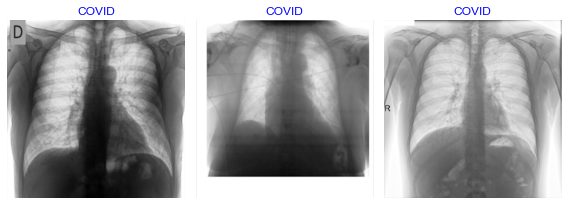

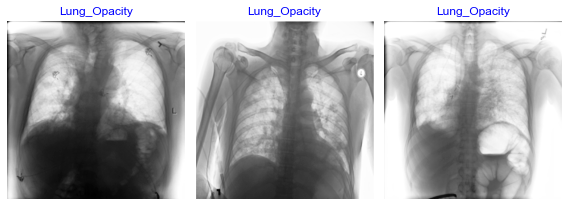

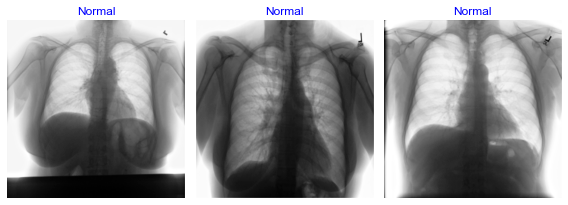

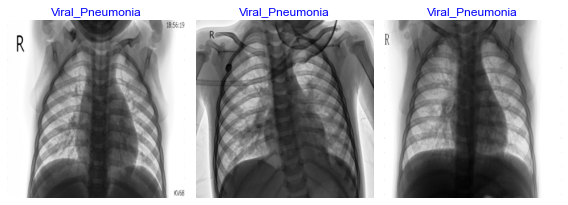

In [58]:
df = merged_df
n = 3
plot_size = (8,6)
target_col = 'label'

# Call function 
plot_images_per_label(df, target_col, n, plot_size)

## B) Data Inspection and Cleaning

Here we will perform each data cleaning step individually as part of the exploratory analysis. In section E we will integrate the cleaning steps into a unified data preprocessing pipeline that can be incorporated into machine learning pipelines.

In [59]:
# Dataset shape
print(f'There are {metadata.shape[0]} images in the metadata file')

There are 21165 images in the metadata file


In [60]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            21165 non-null  int64 
 1   file_name             21165 non-null  object
 2   image_data_grayscale  21165 non-null  object
 3   file_format           21165 non-null  object
 4   image_shape           21165 non-null  object
 5   label                 21165 non-null  object
dtypes: int64(1), object(5)
memory usage: 992.2+ KB


**Unique values**

In [61]:
# Find unique values 
for col in metadata.columns[3:]:
    metadata[col].value_counts(ascending=True)
    print(col, metadata[col].unique())

PNG    21165
Name: file_format, dtype: int64

file_format ['PNG']


(299, 299)    21165
Name: image_shape, dtype: int64

image_shape ['(299, 299)']


Viral Pneumonia     1345
COVID               3616
Lung_Opacity        6012
Normal             10192
Name: label, dtype: int64

label ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']


### Dataset class distribution
- For classification algorithms, dataset imbalance can influence the recall of under-represented classes.
- Check the proportions of the target variable values in the dataset

Check data balance for "metadata"



label  count  percentage
0           Normal  10192        48.2
1     Lung_Opacity   6012        28.4
2            COVID   3616        17.1
3  Viral Pneumonia   1345         6.4

'\n'

Check data balance for "merged_df"



label  count  percentage
0           Normal  10192        48.2
1     Lung_Opacity   6012        28.4
2            COVID   3616        17.1
3  Viral_Pneumonia   1345         6.4

'\n'

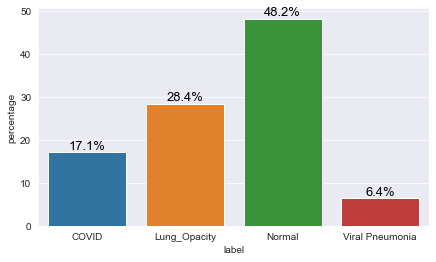

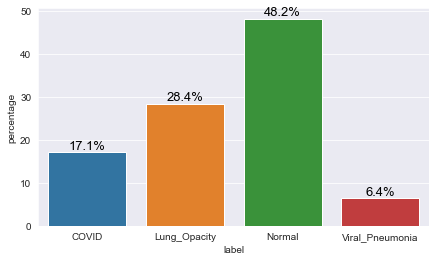

In [62]:
print_in_color('Check data balance for "metadata"',(0,255,255), (55,65,80))
target = metadata.label.astype('category')
check_dataset_balance(target)

print_in_color('Check data balance for "merged_df"',(0,255,255), (55,65,80))
target = merged_df.label.astype('category')
check_dataset_balance(target)

**Observations:** <br>
- There are a total of 21,165 images
- Dataset is imbalanced and will try to fix that with data augmentation
- All images are in PNG format
- All images are size (299,299)
- label has 4 different classes and will need to be One_hot Encoded

## C) Train/test Split
As best practice, let's cache and split the dataset before performing any pre-processing

In [63]:
df = merged_df
target_col = 'label'
train_split = 0.8

# Call the function to split the DF
train_df, val_df, test_df = split_df(df, target_col, train_split)


After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    


**Check for split equality** <br>
Before splitting:
- COVID 17.1%
- Lung_Opacity 28.4%
- Normal 48.2%
- Viral Penumonia 6.4%

Check data balance for "train_df"



label  count  percentage
0           Normal   8154        48.2
1     Lung_Opacity   4809        28.4
2            COVID   2893        17.1
3  Viral_Pneumonia   1076         6.4

'\n'

Check data balance for "val_df"



label  count  percentage
0           Normal   1019        48.2
1     Lung_Opacity    601        28.4
2            COVID    361        17.1
3  Viral_Pneumonia    135         6.4

'\n'

Check data balance for "test_df"



label  count  percentage
0           Normal   1019        48.1
1     Lung_Opacity    602        28.4
2            COVID    362        17.1
3  Viral_Pneumonia    134         6.3

'\n'

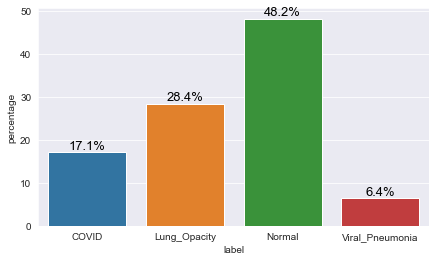

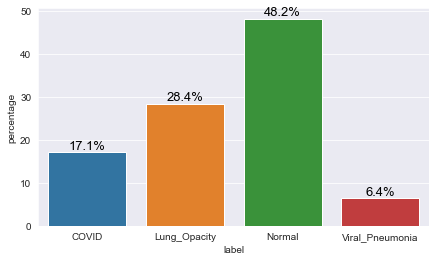

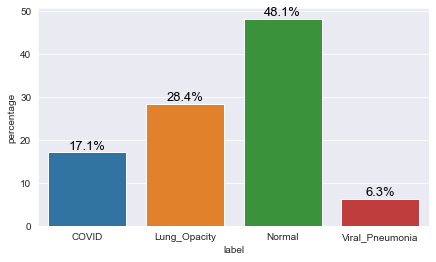

In [64]:
print_in_color('Check data balance for "train_df"',(0,255,255), (55,65,80))
target = train_df.label.astype('category')
check_dataset_balance(target)

print_in_color('Check data balance for "val_df"',(0,255,255), (55,65,80))
target = val_df.label.astype('category')
check_dataset_balance(target)

print_in_color('Check data balance for "test_df"',(0,255,255), (55,65,80))
target = test_df.label.astype('category')
check_dataset_balance(target)

**Observations** <br>
The split was perfectly done, giving the same percentages as before the split

## D) Image pre-processing

### Training set pre-processing

As seen above, the dataset greatly favour the Normal Class which is the Class that we are not particularly interested in training our model. If we leave it like that, our model will become good at predicting correctly Normal images. Since we want our model to learn how to predict the other 3 Classes, we should reduce the number of Normal images in the training set and increase the number of Covid, Lung_Opacity and Viral_Pneumonia images. <br>

We'll start by removing random Normal images in the train_df to a total of 4809 images (same number as the second largest Class) and then we'll create a new dataframe with new images for the other 2 minority Classes so that all Classes have the same number of images after processing.

**(i) TRIMMING**

In [65]:
df = train_df
max_samples = 4809
target = 'label'
trim_df = trim(df, max_samples, target)


Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Total number of images in trim_df:

13587 



**(ii) AUGMENTATION** <br>
The following custom function will first create directories to hold the augmented images, then create the augmented images, and finally merge them to the original trim_df. <br>
<br>
This "offline" image augmentation is necessary to balance our dataset and because we cannot use an image generator with Scikit-Learn GridSearchCV, meaning that we need to create the images beforehand and feed the original and the augmented images to the model for Grid search later on. <br>
<br>
One point to keep in mind is that these newly created images will act as "original" images when read by the ImageGenerator during training. Therefore, the modifications applied to new created from the minority Classes will be gentle so that they look like the originals when being fed into the generator later during training.

**>> Offline <<**

In [66]:
# Use ImageDataGenerator for Offline Image Augmentation and create a new DF with augmented images combined with the original trim_df
start = time()

df = trim_df
max_samples = 4809
image_col = 'file_path'
target_col = 'label'
image_size = (100,100) # limit with my local GPU
img_format = 'png'

train_df_balanced = aug_train(df, max_samples, image_col, target_col, image_size, img_format, path_to_cwd)

#--------------------------------------------------------------------------------------------------------------------
print(f'Elasped time : {np.round((time() - start)/60, 2)} min') # 1 min

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Viral_Pneumonia    4809
Lung_Opacity       4809
Normal             4809
COVID              4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Elasped time : 0.67 min


**Note:** <br>
Since we couldn't use the generator to perform OHE on the label variable during the offline augmentation process, let's re-create the same generator object for "on-the-fly" image augmentation on the training set but also converting the label to categorical. <br>
These images will be feed to the neural network so that it can augment on the fly during training.<br>
We will use .flow_from_dataframe() to generate batches of image data (and their labels) using our balanced dataset

**>> On-the-fly <<**

In [67]:
# Create the iterator for augmenting the balanced classes images on-the-fly
df = train_df_balanced
image_col = df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
batch_size = 64 

train_generator = train_gen(df, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size)

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[3, 0, 1, 1, 2, 3, 1, 0, 3, 2, 3, 2, 2, 3, 0, 0, 1, 2, 0, 1] 



### Validation set pre-processing
With Keras Image Data Generator, we can **rescale** the pixel values, **resize** the images, and apply random **transformation** techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen created earlier included some transformations to augment the train set.

In [68]:
# Rescale and Resize only
val_generator = val_gen(val_df, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size)

Found 2116 validated image filenames belonging to 4 classes.

val_generator:
 <class 'keras.preprocessing.image.DataFrameIterator'>

Number of images in the val_generator:

2116

List of classes in the val_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the val_generator:

[0, 0, 2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 2, 1, 2] 



### Post-processing

**Plot random images from the train_generator (after image processing)**

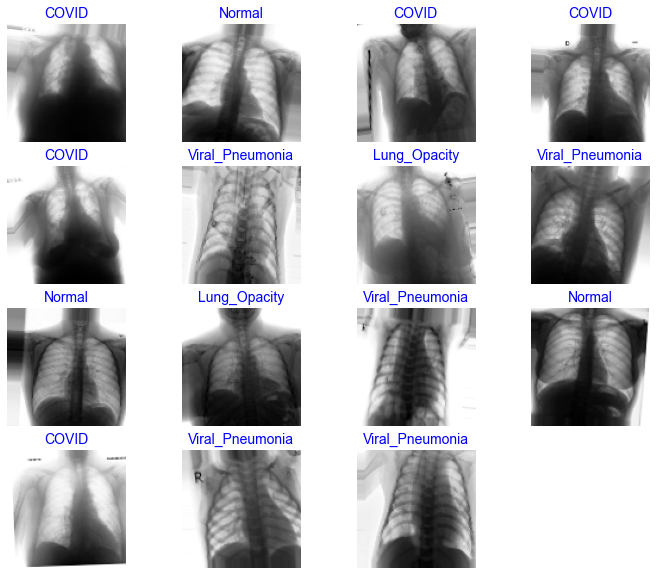

In [69]:
# Plot random images from the train_generator
generator = train_generator
n = 15
plot_size = (12,10)

# Call function 
image_samples_gen(generator, n, plot_size)

**Information needed for modelling**

In [70]:
# %%script False

batch = train_generator.next() # arrays for 1 batch determined earlier
img_gen, label_gen = batch # images and labels inside the batch
batch_size, height, width, num_channels = img_gen.shape
img_size = (height, width) 
num_classes = len(train_generator.class_indices)
input_shape = (height, width, num_channels)

nb_train_samples = train_generator.samples
nb_val_samples = val_generator.samples

print_in_color('\nImage info to use for model training:',(0,255,255), (55,65,80))
print(f'''height = {height}
width = {width}
num_channels = {num_channels} 
img_size = {img_size}
num_classes = {num_classes}
input_shape = {input_shape}
nb_train_samples = {nb_train_samples}
nb_val_samples = {nb_val_samples}

Other image-related info:
pixel_range: {np.min(img_gen)}, {np.max(img_gen)} (normalized by the generator)
dtype: {img_gen.dtype} (converted by the generator)
''')


Image info to use for model training:

height = 100
width = 100
num_channels = 1 
img_size = (100, 100)
num_classes = 4
input_shape = (100, 100, 1)
nb_train_samples = 19236
nb_val_samples = 2116

Other image-related info:
pixel_range: 0.0, 0.9960784912109375 (normalized by the generator)
dtype: float32 (converted by the generator)



# 2) Baseline Model - 2 epochs

## Pre-processing data

**Prepare X_train and y_train** <br>
We'll use the full dataset (original and augmented images) for our training data. But first we need to convert the data into arrays

In [71]:
# Convert aug_train_df into arrays, rezise to (100,100) and rescale (0,1)
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = train_df_balanced.label
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 19236
Shape of images: (19236, 100, 100, 1)

X_train shape: (19236, 100, 100, 1) 
y_train shape: (19236,)




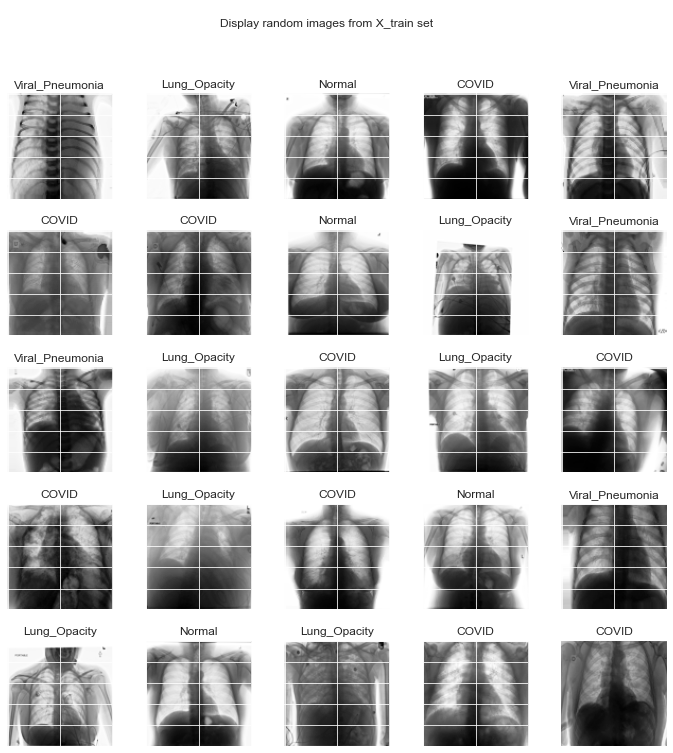

In [72]:
# Plot random images from X_train set
image_samples_array(X_train, y_train, n=5, plot_size=(12,12))  

Note: <br>
To apply a classifier on this data, we also need to flatten the images, turning each 2D array of grayscale values from shape (100, 100) into shape (1000,). Subsequently, the entire dataset will be of shape (n_samples, n_features), where n_samples is the number of images and n_features (1000) is the total number of pixels in each image.

In [73]:
# Flatten the images
n_samples = len(X_train)
X_train = X_train.reshape((n_samples, -1))

# Encode target variable to 1D array
y_train = LabelEncoder().fit_transform(y_train)
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))


X_train shape: (19236, 10000) 
y_train shape: (19236,)




**Prepare X_val and y_val** <br>
We need to convert X_val and y_val to arrays, resize and rescale and then flatten into 2D arrays

In [74]:
# Convert X_val and y_val into arrays, rezise to (100,100) and rescale (0,1)
X_val = img_from_df_to_array(img_col=val_df.file_path)
y_val = val_df.label
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 2116
Shape of images: (2116, 100, 100, 1)

X_val shape: (2116, 100, 100, 1) 
y_val shape: (2116,)




In [75]:
# Flatten the images
n_samples = len(X_val)
X_val = X_val.reshape((n_samples, -1))

# Encode target variable to 1D array
y_val = LabelEncoder().fit_transform(y_val)
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}',(255,0,255),(55,65,80))


X_val shape: (2116, 10000) 
y_val shape: (2116,)



## Train Baseline

In [37]:
start = time()

# ------------ Step 1:  define estimator ------------
estimator = SVC()

# ------------ Step 2:  define HP search space ------------
params = dict()
params['C'] = Real(1e-6, 100.0, 'log-uniform')
params['gamma'] = Real(1e-6, 100.0, 'log-uniform')
params['degree'] = Integer(1,5)
params['kernel'] = Categorical(['linear', 'poly', 'rbf'])

# ------------ Step 3:  perform HP Optimization ------------
cv = 2
n_iter = 2 # 10
n_points = 2
search = BayesSearchCV(estimator, search_spaces=params, n_jobs=-1, cv=cv, return_train_score=True, n_iter=n_iter, n_points=n_points,
                       refit=True, verbose=1)

search_results = search.fit(X_train[:1000], y_train[:1000])

# ------------------------------------------------------------------------------------------------------------------------------
baseline_tuned = (time()-start)/60 # 1 min
print_in_color(f'\nElasped time for the entire "baseline_untuned" : {baseline_tuned:.2f} min',(0,255,0),(55,65,80))
%chime

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Elasped time for the entire "baseline_untuned" : 0.36 min



## Evaluate Baseline Model

**(i) Evaluate - best Baseline**

In [38]:
acc_val_base = max(search_results.cv_results_['mean_test_score']); print(f'Tuned Baseline Accuracy (val): {acc_val_base*100}%')
acc_train_base = max(search_results.cv_results_['mean_train_score']); print(f'Tuned Baseline Accuracy (train): {acc_train_base*100}%')
print('\nBest hyperparameters:')

for k,v in search_results.best_params_.items():
    print(k,':', v)

Tuned Baseline Accuracy (val): 67.5%
Tuned Baseline Accuracy (train): 81.5%

Best hyperparameters:
C : 14.79077147153563
degree : 2
gamma : 0.0002179587422140049
kernel : poly


**(ii) Predictions**

In [39]:
start = time()

model = search_results.best_estimator_

y_pred_train = model.predict(X_train[:1000])
y_pred_val = model.predict(X_val[:1000])
y_true_train = y_train[:1000]
y_true_val = y_val[:1000]

baseline_cv_results = (time()-start)/60 # 1 min
print_in_color(f'\nElasped time for the entire "baseline_untuned" : {baseline_cv_results:.2f} min',(0,255,0),(55,65,80))
%chime


Elasped time for the entire "baseline_untuned" : 0.17 min



**(iii) Summary report**

In [40]:
# Create classification report
report_train = classification_report(y_true_train, y_pred_train, output_dict=True)
report_val = classification_report(y_true_val, y_pred_val, output_dict=True)

# Extract metrics
rec_train_base = report_train['macro avg']['recall']
rec_val_base = report_val['macro avg']['recall']

# Create dictionnary
data = [{'Accuracy_train':acc_train_base, 'Accuracy_val':acc_val_base,
         'Recall_train':rec_train_base, 'Recall_val':rec_val_base,
         'Loss_train':0, 'Loss_val':0}]
  
# Create DF
baseline_results_df = pd.DataFrame(data, index=['Baseline model (SM)'],
                                 columns=['Accuracy_train', 'Accuracy_val', 'Recall_train', 'Recall_val', 'Loss_train', 'Loss_val'])
display(baseline_results_df)

# Save results to CSV file
os.makedirs('results', exist_ok=True) # make new directory if not exists
baseline_results_df.to_csv('results/baseline_results_df.csv', index=True, index_label='model')

Accuracy_train  Accuracy_val  Recall_train  Recall_val  \
Baseline model (SM)           0.815         0.675      0.800743    0.690393   

                     Loss_train  Loss_val  
Baseline model (SM)           0         0

# 3) CNN - Single Machine - 2 epochs

# A) Basic CNN Model

## Build and Compile

In [32]:
model = create_cnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Conv2D)              (None, 100, 100, 32)      832       
                                                                 
 norm1 (BatchNormalization)  (None, 100, 100, 32)      128       
                                                                 
 activation1 (Activation)    (None, 100, 100, 32)      0         
                                                                 
 reducer1 (MaxPooling2D)     (None, 50, 50, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 50, 50, 64)        18496     
                                                                 
 norm2 (BatchNormalization)  (None, 50, 50, 64)        256       
                                                                 
 activation2 (Activation)    (None, 50, 50, 64)        0

## Callbacks

In [85]:
# Clear out prior logging data.
# !rm -rf callbacks/logs/image
callback_hpo, callback_training = callbacks(path_to_cwd, name='untuned')

## TensorBoard
Open TensorBoard directly into the notebook and also on the browser specifying the port number.

In [38]:
# Load TensorBoard Logs (or http://localhost:6006)
# %tensorboard --logdir callbacks/logs --port=6006

## Model Training - Basic

**We can now use the train_generator and val_ generator created earlier to train and validate our basic model**

- x: np.array (X_train, X_val) or generator returning (inputs, targets)
- y: target, np.array (y_train, y_val) or generator (val_generator)
- validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. **The validation data is selected from the last samples in the x and y data provided, before shuffling.** This argument is not supported when x is a dataset, generator or keras.utils.Sequence instance. 
- validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. validation_data will override validation_split. 
- shuffle: whether to shuffle the training data before each epoch

In [87]:
start = time()
# Fit model
epochs = 2 
print_in_color(f'\nModel training with no hyperparameters tuning started...',(0,255,0),(55,65,80))
model, history = train_model_gen(model, train_generator, val_generator, epochs)

# ------------------------------------------------------------------------------------------------------------------------------
pipeline_untuned_cnn = (time()-start)/60 # 3 min
print_in_color(f'\nElasped time for the entire "pipeline_untuned_cnn" : {pipeline_untuned_cnn:.2f} min',(0,255,0),(55,65,80))


Model training with no hyperparameters tuning started...


Model training using the best hyperparameters started...

Epoch 1/2
300/300 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.7153 - recall: 0.6371
Epoch 1: val_loss improved from inf to 2.50889, saving model to /Sylvie_notebooks/DS4\callbacks\untuned_best_weights-ep01-loss2.51.hdf5

val/train loss ratio: 3.61

300/300 [==============================] - 82s 262ms/step - loss: 0.6948 - accuracy: 0.7153 - recall: 0.6371 - val_loss: 2.5089 - val_accuracy: 0.3087 - val_recall: 0.3068 - lr: 0.0020
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8139 - recall: 0.7824
Epoch 2: val_loss improved from 2.50889 to 1.37873, saving model to /Sylvie_notebooks/DS4\callbacks\untuned_best_weights-ep02-loss1.38.hdf5

val/train loss ratio: 2.89

300/300 [==============================] - 70s 233ms/step - loss: 0.4765 - accuracy: 0.8139 - recall: 0.7824 - val_loss: 1.3787 - val_accur

## Save trained basic model

In [35]:
model_name = 'trained_untuned_cnn_SM'
generator = train_generator
img_size = img_size
pixel_scaler = 255 

# Save architecture & weights and create a generator info csv file
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)


The entire model was saved in the saved_models folder as:

trained_untuned_cnn_SM.h5

Class file was saved in the saved_models folder as:

class_df_trained_untuned_cnn_SM_model.csv 



## Evaluate basic model

In [88]:
get_weights = model.get_layer('Output').get_weights()
weights = get_weights[0]
biases = get_weights[1]

print('Output layer weights.shape:', weights.shape)
print('Ouput layer biases.shape:', biases.shape)

Output layer weights.shape: (64, 4)
Ouput layer biases.shape: (4,)


**(i) Performance Metrics**

In [89]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall', 'lr'])


In [90]:
model_name = 'Untuned basic Model'
name = 'untuned'
untuned_results_df =  metrics_train_val(history, model_name, name, index_name='Untuned CNN (SM)') # create DF for results


Performance Metrics from best_epoch for 
	"Untuned basic Model"	


    Train Accuracy: 		81.4%
    Validation Accuracy: 	46.4%
    Train Recall: 		0.78
    Validation Recall: 		0.41
    Train Loss: 		0.48
    Validation Loss: 		1.38
    


**(ii) Plot Learning Curves and Recall curves** 


--------------- Learning Curves and Recall ---------------

 Best epoch = 2 



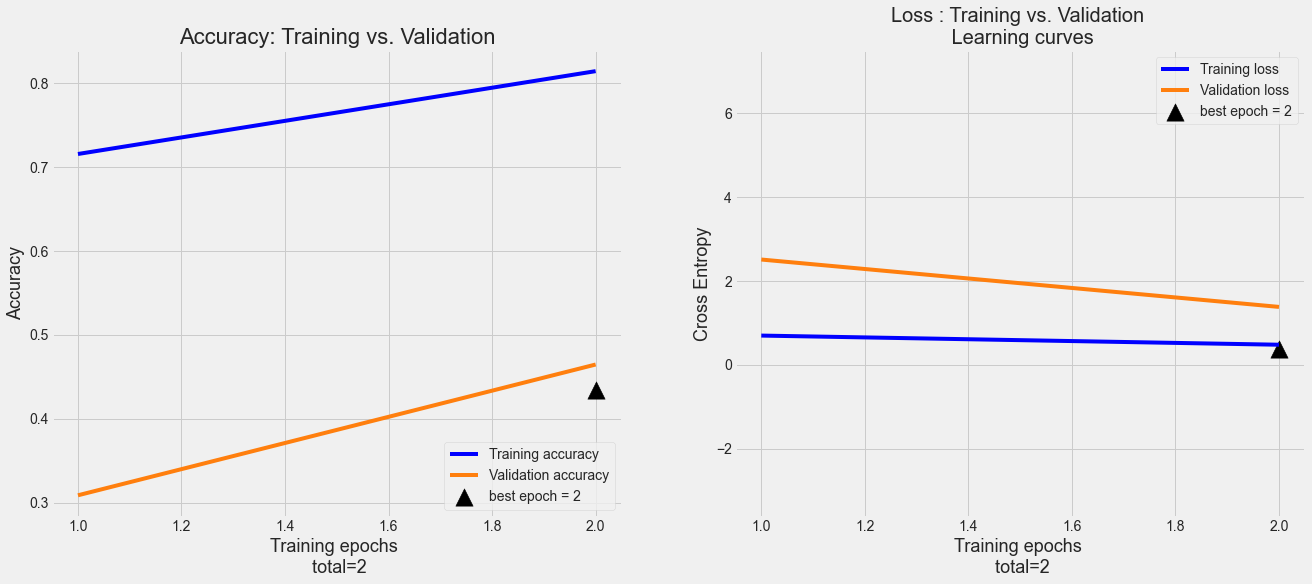

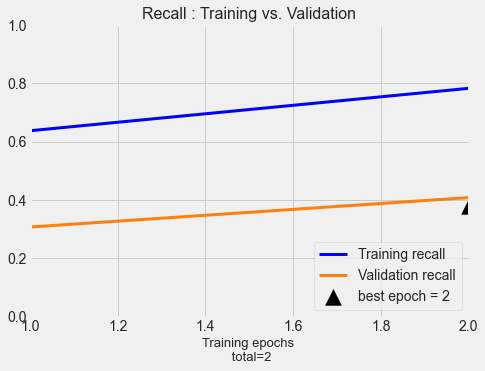

In [91]:
plot_learning_curve_and_recall(history)

# B) Tune CNN Model

## (i) HalvingGridSearchCV

**Prepare data** <br>
Convert aug_train_df into X_train and y_train arrays

In [32]:
# Convert aug_train_df into arrays
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = tf.keras.utils.to_categorical(y=train_df_balanced.label.factorize()[0])
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 19236
Shape of images: (19236, 100, 100, 1)

X_train shape: (19236, 100, 100, 1) 
y_train shape: (19236, 4)




In [33]:
# Convert val generator into X_val and y_val arrays
X_val = np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
y_val = np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
print_in_color('\nValidation data from val_generator after conversion to numpy array:',(0,255,255),(55,65,80))
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))


Validation data from val_generator after conversion to numpy array:


X_val shape: (2116, 100, 100, 1) 
y_val shape: (2116, 4)




In [34]:
# GridSearch valid metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [35]:
# Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='GS_SM')

**Create CNN model for GridSearch**

In [36]:
def cnn_model_gs(rate=0.2, filters=64, units=64):
   
    n, height, width, num_channels = X_train.shape
    input_shape = (height, width, num_channels)
    num_classes = y_train.shape[1]
    
    NUM_LAYER_CONV = 3
    NUM_LAYER_DENSE = 3

    
    model = Sequential()

    model.add(Conv2D(filters=filters, kernel_size=(5,5), padding='same', input_shape=input_shape, name='filters_conv_input'))
    model.add(BatchNormalization(name='norm_conv_input'))
    model.add(Activation('relu', name='activation_conv_input'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid', name='reducer_conv_input'))

    for i in range(NUM_LAYER_CONV):    
        model.add(Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='glorot_uniform', padding='same', name=f'filters_conv_{i+2}'))
        model.add(BatchNormalization(name=f'norm_conv_{i+2}'))
        model.add(Activation('relu', name=f'activation_conv_{i+2}'))
        model.add(MaxPooling2D(pool_size=(2,2), padding='valid', name=f'reducer_conv_{i+2}'))
        model.add(Dropout(rate=rate, name=f'dropout_conv_{i+2}'))

        
    model.add(Flatten(name='flatten1'))
    
    
    for i in range(NUM_LAYER_DENSE):        
        model.add(Dense(units=units, kernel_initializer='glorot_uniform', name=f'nodes_dense_{i+1}'))
        model.add(BatchNormalization(name=f'norm_dense_{i+1}'))
        model.add(Activation('relu', name=f'activation_dense_{i+1}'))
        model.add(Dropout(rate=rate, name=f'dropout_dense_{i+1}')) 

        
    model.add(Dense(num_classes, name='Output'))
    model.add(Activation('softmax', name='activation7'))
    
    
    # Compile model
    metrics = ['accuracy', Recall(name='recall')]
    loss =  'categorical_crossentropy' # b/c one-hot vector labels format, otherwise parse_categorical_crossentropy

    model.compile(optimizer='adam', loss=loss, metrics=metrics)

    return model

**Create a KerasClassifier Wrapper to use Scikit-Learn GridSearchCV** <br>
Note: <br>
To use a Keras model in Scikit-Learn, we need to use the KerasClassifier wrapper. We need to pass a function which creates and returns a model.

In [83]:
start = time()

# Define grid for HP search space
NUM_FILTERS_CONV = [32,128,256]
NUM_NODES_DENSE = [32,128,256]
DROPOUT =  [0.0, 0.2, 0.5]
epochs = 1    # going through the entire dataset once
cv = 2    # 5; default StratifiedKFold

# Define search dictionnary
param_grid = dict(rate =               DROPOUT,
                  filters =            NUM_FILTERS_CONV,
                  units =              NUM_NODES_DENSE)

# Create a Keras Classifier model
keras_model = KerasClassifier(cnn_model_gs)

# GridSearchCV
grid = HalvingGridSearchCV(estimator=keras_model, param_grid=param_grid, cv=cv, verbose=0) 

print_in_color(f'\nGridSearch hyperparameters tuning started...', (255,0,255),(55,65,80))

search_grid = ParameterGrid(param_grid)
print (f"Number of grid hyperparameters combinations: {len(search_grid)}")
print (f"Total number of models that will be fitted using GridSearchCV: {len(search_grid)*cv}")

grid_results = grid.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callback_hpo, 
                       validation_data=(X_val, y_val), shuffle=True, verbose=0) 

# ------------------------------------------------------------------------------------------------------------------------------
pipeline_kerasClassifier_GS = (time()-start)/60 # 11 min
print_in_color(f'\nElasped time for the entire "pipeline_kerasClassifier_GS" : {pipeline_kerasClassifier_GS:.2f} min',(0,255,0),(55,65,80))

**Best hyperparameters**

In [56]:
best_hps = grid_results.best_params_
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']

print_in_color('\nOptimal hyperparameters with GridSearch:', (0,255,0), (55,65,80))
for k, v in best_hps.items():
    print(k, ':', v)
    
print_in_color('\nGiving a model accuracy (validation set):', (0,255,255), (55,65,80)) 
print(round(grid_results.best_score_*100,1), '%')

msg = '\nFor more details, below are all hyperparameters combinations searched and their relative accuracy (training set):'
print_in_color(msg, (0,255,0), (55,65,80))
for mean, param in zip(means, params):
    print(f'\n{mean*100:.1f}% with:')
    for k, v in param.items():
        print(f'\t{k} : {v}')



Optimal hyperparameters with GridSearch:

filters : 128
rate : 0.2
units : 128

Giving a model accuracy (validation set):

25.0 %

For more details, below are all hyperparameters combinations searched and their relative accuracy (training set):


28.5% with:
	filters : 32
	rate : 0.0
	units : 32

23.5% with:
	filters : 32
	rate : 0.0
	units : 128

25.8% with:
	filters : 32
	rate : 0.0
	units : 256

25.7% with:
	filters : 32
	rate : 0.2
	units : 32

25.4% with:
	filters : 32
	rate : 0.2
	units : 128

22.5% with:
	filters : 32
	rate : 0.2
	units : 256

28.2% with:
	filters : 32
	rate : 0.5
	units : 32

29.6% with:
	filters : 32
	rate : 0.5
	units : 128

24.0% with:
	filters : 32
	rate : 0.5
	units : 256

24.6% with:
	filters : 128
	rate : 0.0
	units : 32

28.1% with:
	filters : 128
	rate : 0.0
	units : 128

29.4% with:
	filters : 128
	rate : 0.0
	units : 256

24.6% with:
	filters : 128
	rate : 0.2
	units : 32

27.0% with:
	filters : 128
	rate : 0.2
	units : 128

24.2% with:
	filters : 1

**Re-train the model with the best hyperparameters**

In [57]:
start = time()
model = grid_results.best_estimator_.model

# Train model with best HP
epochs = 50  
model, history = train_model_gen(model, train_generator, val_generator, epochs) # 3 min

# ------------------------------------------------------------------------------------------------------------------------------
print_in_color(f'\nElasped time for the entire "pipeline_kerasClassifier_GS" : {(time()-start)/60 } min',(0,255,0),(55,65,80))


Model training using the best hyperparameters started...

Epoch 1/2
300/300 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.7698 - recall: 0.7265
Epoch 1: val_loss improved from inf to 1.74049, saving model to /Sylvie_notebooks/DS4\callbacks\GS_SM_best_weights-ep01-loss1.74.hdf5

val/train ratio: 3.00

300/300 [==============================] - 69s 227ms/step - loss: 0.5801 - accuracy: 0.7698 - recall: 0.7265 - val_loss: 1.7405 - val_accuracy: 0.2770 - val_recall: 0.2538 - lr: 0.0010
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.8232 - recall: 0.7975
Epoch 2: val_loss improved from 1.74049 to 1.14121, saving model to /Sylvie_notebooks/DS4\callbacks\GS_SM_best_weights-ep02-loss1.14.hdf5

val/train ratio: 2.50

300/300 [==============================] - 71s 237ms/step - loss: 0.4559 - accuracy: 0.8232 - recall: 0.7975 - val_loss: 1.1412 - val_accuracy: 0.4555 - val_recall: 0.3788 - lr: 0.0010
Elasped time : 2.35 min

El

**Tuned-GS model evaluation**

In [58]:
model_name = 'Tuned_GS CNN Model'
name = 'GS'
GS_results_df =  metrics_train_val(history, model_name, name, index_name='GridSearch (SM)') # create DF for GS results


Performance Metrics from best_epoch for 
	"Tuned_GS CNN Model"	


    Train Accuracy: 		82.3%
    Validation Accuracy: 	45.5%
    Train Recall: 		0.80
    Validation Recall: 		0.38
    Train Loss: 		0.46
    Validation Loss: 		1.14
    


In [59]:
# Save best_model GS
model_name='best_tuned_GS'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)


The entire model was saved in the saved_models folder as:

best_tuned_GS.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_GS_model.csv 



**Plot learning curves and Recall** <br>
Plot the Learning Curve to examine if underfitting or overfitting happened during training <br>
The black arrow in the Loss graph shows the epoch chosen for the Final Model saved using the ModelCheckPoint Callback


--------------- Learning Curves and Recall ---------------

 Best epoch = 2 



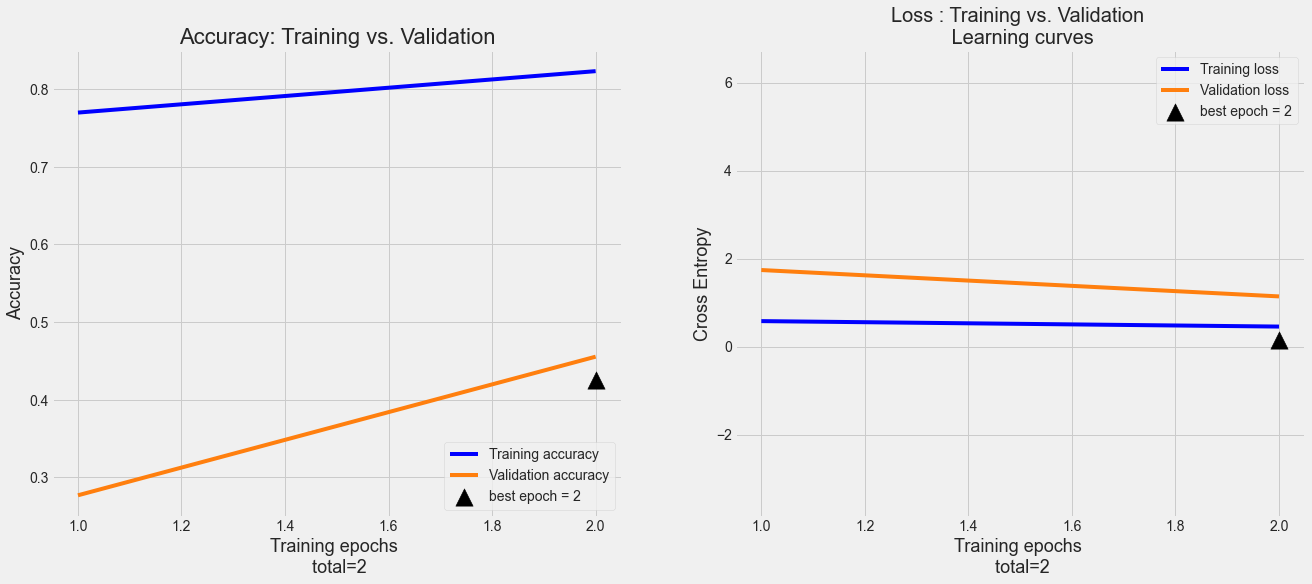

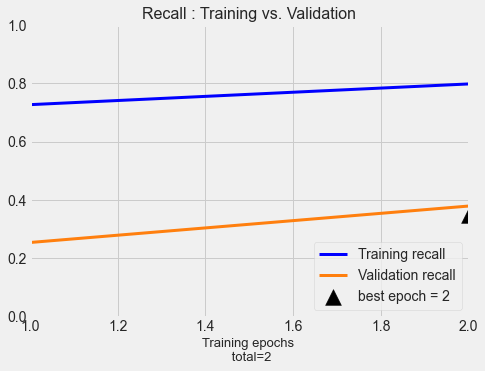

In [60]:
# Best_model_GS
plot_learning_curve_and_recall(history)

## (ii) RandomSearch

In [92]:
# Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='RS_SM')

**Create a Keras model to use with Keras-Tuner**

In [93]:
def kerastuner_cnn_model(hp):
    """
    Builds CNN model
    Configure hyperparameter space to search
    Returns keras_model ready to be tuned using Keras-Tuner
    """

    batch = train_generator.next() # arrays for 1 batch determined earlier
    img_gen, label_gen = batch # images and labels inside the batch
    batch_size, height, width, num_channels = img_gen.shape
    img_size = (height, width) 
    input_shape = (height, width, num_channels)
    num_classes = len(train_generator.class_indices.keys())
    
    
     # -------------------- Step 1: RandomSearch --------------------

    NUM_FILTERS_INPUT = hp.Int('n_filters_input', 32,256,step=32)
    NUM_LAYER_CONV = hp.Int('n_layers_conv', 1,5,step=1)
    NUM_LAYER_DENSE = hp.Int('n_layers_dense', 1,5,step=1)
    
    REGULIZER_CONV = hp.Choice('regulizer_conv', ['l1','l2','l1_l2'])
    REGULIZER_DENSE = hp.Choice('regulizer_dense', ['l1','l2','l1_l2'])
    INITIALIZER_CONV = hp.Choice('initializer_conv', ['glorot_uniform','random_normal','random_uniform'])
    INITIALIZER_DENSE = hp.Choice('initializer_dense', ['glorot_uniform','random_normal','random_uniform'])
                         
    DROPOUT_CONV = hp.Float('dropout_rate_conv', 0.0,0.5,step=0.1) 
    DROPOUT_DENSE = hp.Float('dropout_rate_dense', 0.0,0.5,step=0.1) 
    
 
    # -------------------- Step 1: Build model --------------------
    
    model = Sequential()

    model.add(Conv2D(NUM_FILTERS_INPUT, kernel_size=(5,5), padding='same', input_shape=input_shape, name='filters_conv_input'))
    model.add(BatchNormalization(name='norm_conv_input'))
    model.add(Activation('relu', name='activation_conv_input'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid', name='reducer_conv_input'))

    for i in range(NUM_LAYER_CONV):    
        model.add(Conv2D(hp.Int(f'n_filters_conv_{i+2}', 32,512,step=32), 
                         (3,3), kernel_initializer=INITIALIZER_CONV, kernel_regularizer=REGULIZER_CONV, padding='same', name=f'filters_conv_{i+2}'))
        model.add(BatchNormalization(name=f'norm_conv_{i+2}'))
        model.add(Activation('relu', name=f'activation_conv_{i+2}'))
        if hp.Choice(f'pooling_conv_{i+2}', ['avg','max']) == 'max':
            model.add(MaxPooling2D(pool_size=(2,2), padding='valid', name=f'reducer_conv_{i+2}'))
        else:
            model.add(AveragePooling2D(pool_size=(2,2), padding='valid', name=f'reducer_conv_{i+2}'))
        model.add(Dropout(DROPOUT_CONV, name=f'dropout_conv_{i+2}'))
    
    
    model.add(Flatten(name='flatten'))
    
    
    for i in range(NUM_LAYER_DENSE):        
        model.add(Dense(hp.Int(f'n_nodes_dense_{i+1}', 32,512,32), 
                        kernel_initializer=INITIALIZER_DENSE, kernel_regularizer=REGULIZER_DENSE, name=f'nodes_dense_{i+1}'))
        model.add(BatchNormalization(name=f'norm_dense_{i+1}'))
        model.add(Activation('relu', name=f'activation_dense_{i+1}'))
        model.add(Dropout(DROPOUT_DENSE, name=f'dropout_dense_{i+1}')) 
        
        
    model.add(Dense(num_classes, name='Output'))
    model.add(Activation('softmax', name='activation7'))
   
    # Compile
    metrics = ['accuracy', Recall(name='recall')]
    optimizer = Adam(learning_rate=1e-3*batch_size/32)
    loss = 'categorical_crossentropy' # b/c one-hot vector labels format, otherwise parse_categorical_crossentropy
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

**Use Keras-Tuner to perform RandomSearch**

In [94]:
start = time()
# Make new directory if not exists:
hpo_dir = os.path.join(path_to_cwd, 'HPO')
os.makedirs(hpo_dir, exist_ok=True) # Make new directory if not exists

epochs = 3    # going through the entire dataset once
max_trials = 2 

tuner = RandomSearch(kerastuner_cnn_model,
                     objective='val_accuracy',
                     max_trials=max_trials, # random combinations to try
                     executions_per_trial=1, # num times to try the same combination of HP
                     directory=hpo_dir, 
                     project_name='kerastuner_random',
                     overwrite=True)

print_in_color(f'\nRandomSearch hyperparameters tuning started...', (255,0,255),(55,65,80))

tuner.search(train_generator, validation_data=val_generator, batch_size=batch_size, epochs=epochs, 
             steps_per_epoch=train_generator.samples//batch_size, callbacks=callback_hpo)
    
# ------------------------------------------------------------------------------------------------------------------------------
pipeline_kerastuner_RS = (time()-start)/60 # 2 min
print_in_color(f'\nElasped time for the entire "pipeline_kerastuner_RS" : {pipeline_kerastuner_RS:.2f} min',(0,255,0),(55,65,80))

Trial 2 Complete [00h 01m 09s]
val_accuracy: 0.1706049144268036

Best val_accuracy So Far: 0.1706049144268036
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit

Elasped time for the entire "pipeline_kerastuner_RS" : 2.29 min



**Best hyperparameters**

In [97]:
best_hps = tuner.get_best_hyperparameters(1)[0]

print_in_color(f'\nOptimal hyperparameters with RandomSearch:',(0,255,255), (55,65,80))
print(f'''
Number of filters in input layer \t{best_hps.get("n_filters_input")}

Number of Conv2D layer(s) \t\t{best_hps.get("n_layers_conv")}
Weight Initializer for Conv2D \t\t{best_hps.get("initializer_conv")}
Regulizer for Conv2D \t\t\t{best_hps.get("regulizer_conv")}
Dropout for Conv2D \t\t\t{best_hps.get("dropout_rate_conv")}

Number of Dense layer(s) \t\t{best_hps.get("n_layers_dense")}
Weight Initializer for Dense \t\t{best_hps.get("initializer_dense")}
Regulizer for Dense \t\t\t{best_hps.get("regulizer_dense")}
Dropout for Dense \t\t\t{best_hps.get("dropout_rate_dense")}
''')

print_in_color(f'List of all best hyperparameters with RandomSearch:',(0,255,255), (55,65,80))
pprint.pprint(tuner.get_best_hyperparameters(1)[0].values)



Optimal hyperparameters with RandomSearch:


Number of filters in input layer 	192

Number of Conv2D layer(s) 		2
Weight Initializer for Conv2D 		random_uniform
Regulizer for Conv2D 			l1
Dropout for Conv2D 			0.5

Number of Dense layer(s) 		2
Weight Initializer for Dense 		glorot_uniform
Regulizer for Dense 			l2
Dropout for Dense 			0.1




List of all best hyperparameters with RandomSearch:

{'dropout_rate_conv': 0.5,
 'dropout_rate_dense': 0.1,
 'initializer_conv': 'random_uniform',
 'initializer_dense': 'glorot_uniform',
 'n_filters_conv_2': 96,
 'n_filters_conv_3': 32,
 'n_filters_input': 192,
 'n_layers_conv': 2,
 'n_layers_dense': 2,
 'n_nodes_dense_1': 64,
 'n_nodes_dense_2': 32,
 'pooling_conv_2': 'max',
 'pooling_conv_3': 'avg',
 'regulizer_conv': 'l1',
 'regulizer_dense': 'l2'}


**Re-train the model with the best hyperparameters**

In [98]:
# Re-build model
model = tuner.hypermodel.build(best_hps)
# Display model struture
get_kerastuner_structure(tuner, tuner_type='RandomSearch') # show model structure


Architecture of the best model with RandomSearch:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 filters_conv_input (Conv2D)  (None, 100, 100, 192)    4992      
                                                                 
 norm_conv_input (BatchNorma  (None, 100, 100, 192)    768       
 lization)                                                       
                                                                 
 activation_conv_input (Acti  (None, 100, 100, 192)    0         
 vation)                                                         
                                                                 
 reducer_conv_input (MaxPool  (None, 50, 50, 192)      0         
 ing2D)                                                          
                                                                 
 filters_conv_2 (Conv2D)     (None, 50, 50, 96)        165984    
    

In [99]:
# Train model with best HP
epochs = 2
model, history = train_model_gen(model, train_generator, val_generator, epochs) # 3 min


Model training using the best hyperparameters started...

Epoch 1/2
300/300 [==============================] - ETA: 0s - loss: 5.5651 - accuracy: 0.6161 - recall: 0.4786
Epoch 1: val_loss improved from inf to 4.11608, saving model to /Sylvie_notebooks/DS4\callbacks\RS_SM_best_weights-ep01-loss4.12.hdf5

val/train loss ratio: 0.74

300/300 [==============================] - 72s 233ms/step - loss: 5.5651 - accuracy: 0.6161 - recall: 0.4786 - val_loss: 4.1161 - val_accuracy: 0.1705 - val_recall: 0.1705 - lr: 0.0020
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 2.8969 - accuracy: 0.6565 - recall: 0.5380
Epoch 2: val_loss improved from 4.11608 to 3.56683, saving model to /Sylvie_notebooks/DS4\callbacks\RS_SM_best_weights-ep02-loss3.57.hdf5

val/train loss ratio: 1.23

300/300 [==============================] - 69s 230ms/step - loss: 2.8969 - accuracy: 0.6565 - recall: 0.5380 - val_loss: 3.5668 - val_accuracy: 0.3665 - val_recall: 0.3163 - lr: 0.0020
Elasped time : 2.

**Tuned-RS model evaluation**

In [100]:
model_name = 'Tuned_RS CNN Model'
name = 'RS'
RS_results_df =  metrics_train_val(history, model_name, name, index_name='RandomSearch (SM)') # create DF for RS results


Performance Metrics from best_epoch for 
	"Tuned_RS CNN Model"	


    Train Accuracy: 		65.6%
    Validation Accuracy: 	36.6%
    Train Recall: 		0.54
    Validation Recall: 		0.32
    Train Loss: 		2.90
    Validation Loss: 		3.57
    


In [41]:
# Save best_model RS
model_name = 'best_tuned_RS'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)


The entire model was saved in the saved_models folder as:

best_tuned_RS.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_RS_model.csv 



**Plot learning curves and Recall** <br>
Plot the Learning Curve to examine if underfitting or overfitting happened during training <br>
The black arrow in the Loss graph shows the epoch chosen for the Final Model saved using the ModelCheckPoint Callback


--------------- Learning Curves and Recall ---------------

 Best epoch = 2 



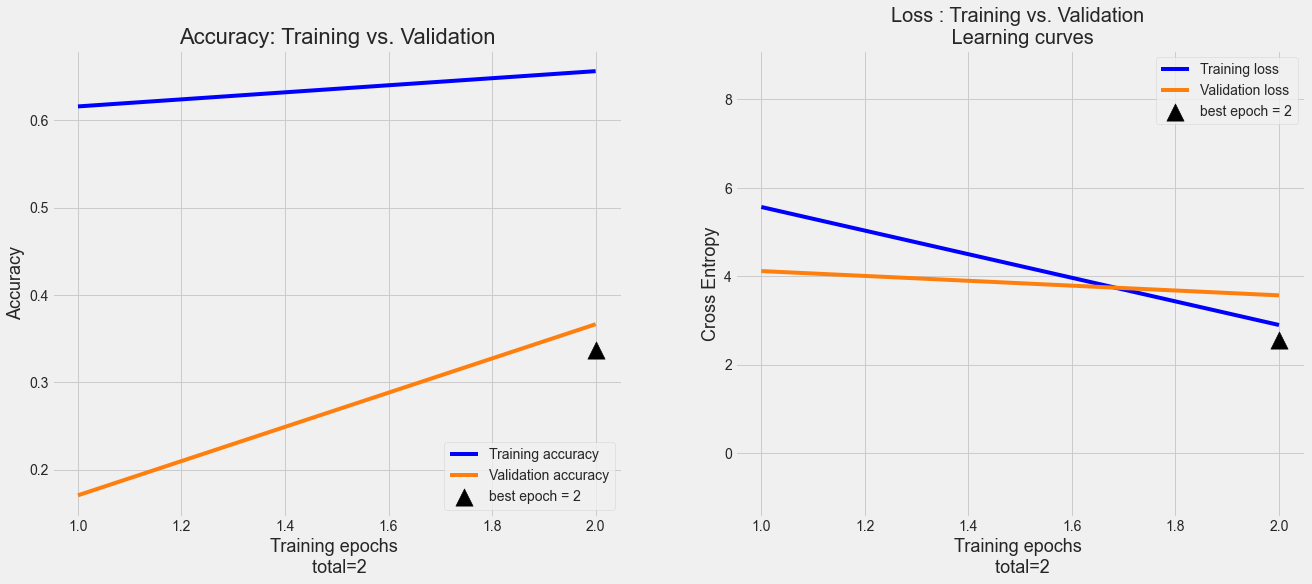

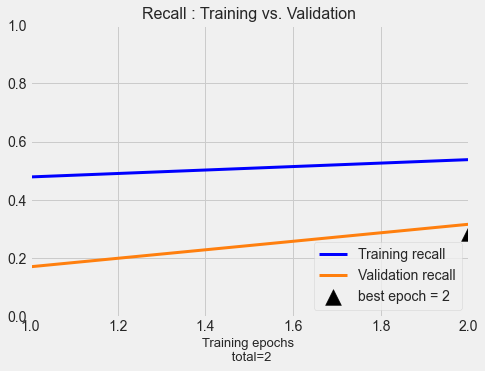

In [101]:
# Best_model_RS
plot_learning_curve_and_recall(history)

## (iii) BayesSearch

In [70]:
# Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='BS_SM')

**Use Keras-Tuner to perform BayesSearch**

In [71]:
start = time()
# Make new directory if not exists: 
hpo_dir = os.path.join(path_to_cwd, 'HPO')
os.makedirs(hpo_dir, exist_ok=True) # Make new directory if not exists

epochs = 1    # going through the entire dataset once
max_trials = 1 # 50

tuner = BayesianOptimization(kerastuner_cnn_model,
                             objective='val_accuracy',
                             max_trials=max_trials, # random combinations to try
                             executions_per_trial=1, # num times to try the same combination of HP
                             directory=hpo_dir,
                             project_name='kerastuner_bayesian',
                             overwrite=True)

print_in_color(f'\nBayesianOptimization hyperparameters tuning started...', (255,0,255),(55,65,80))
tuner.search(train_generator, validation_data=val_generator, batch_size=batch_size, epochs=epochs, 
             steps_per_epoch=train_generator.samples//batch_size)

# ------------------------------------------------------------------------------------------------------------------------------
pipeline_kerastuner_BS = (time()-start)/60 # 2 min
print_in_color(f'\nElasped time for the entire "pipeline_kerastuner_BS" : {pipeline_kerastuner_BS:.2f} min',(0,255,0),(55,65,80))

Trial 1 Complete [00h 01m 11s]
val_accuracy: 0.1706049144268036

Best val_accuracy So Far: 0.1706049144268036
Total elapsed time: 00h 01m 11s
INFO:tensorflow:Oracle triggered exit

Elasped time for the entire "pipeline_kerastuner_BS" : 1.19 min



**Best hyperparameters**

In [72]:
best_hps = tuner.get_best_hyperparameters(1)[0]

print_in_color(f'\nOptimal hyperparameters with BayesSearch:',(0,255,255), (55,65,80))
print(f'''
Number of filters in input layer \t{best_hps.get("n_filters_input")}

Number of Conv2D layer(s) \t\t{best_hps.get("n_layers_conv")}
Weight Initializer for Conv2D \t\t{best_hps.get("initializer_conv")}
Regulizer for Conv2D \t\t\t{best_hps.get("regulizer_conv")}
Dropout for Conv2D \t\t\t{best_hps.get("dropout_rate_conv")}

Number of Dense layer(s) \t\t{best_hps.get("n_layers_dense")}
Weight Initializer for Dense \t\t{best_hps.get("initializer_dense")}
Regulizer for Dense \t\t\t{best_hps.get("regulizer_dense")}
Dropout for Dense \t\t\t{best_hps.get("dropout_rate_dense")}

Optimizer for backpropagation \t\t{best_hps.get("optimizer")}

''')

print_in_color(f'List of all best hyperparameters with BayesSearch:',(0,255,255), (55,65,80))
pprint.pprint(tuner.get_best_hyperparameters(1)[0].values)


Optimal hyperparameters with BayesSearch:


Number of filters in input layer 	256

Number of Conv2D layer(s) 		2
Weight Initializer for Conv2D 		glorot_uniform
Regulizer for Conv2D 			l2
Dropout for Conv2D 			0.5

Number of Dense layer(s) 		5
Weight Initializer for Dense 		random_normal
Regulizer for Dense 			l1_l2
Dropout for Dense 			0.4

Optimizer for backpropagation 		adam


List of all best hyperparameters with BayesSearch:

{'dropout_rate_conv': 0.5,
 'dropout_rate_dense': 0.4,
 'initializer_conv': 'glorot_uniform',
 'initializer_dense': 'random_normal',
 'n_filters_conv_2': 96,
 'n_filters_conv_3': 32,
 'n_filters_input': 256,
 'n_layers_conv': 2,
 'n_layers_dense': 5,
 'n_nodes_dense_1': 256,
 'n_nodes_dense_2': 32,
 'n_nodes_dense_3': 32,
 'n_nodes_dense_4': 32,
 'n_nodes_dense_5': 32,
 'optimizer': 'adam',
 'pooling_conv_2': 'avg',
 'pooling_conv_3': 'avg',
 'regulizer_conv': 'l2',
 'regulizer_dense': 'l1_l2'}


**Re-train the model with the best hyperparameters**

In [73]:
# Re-build model
model = tuner.hypermodel.build(best_hps)
# Display model struture
get_kerastuner_structure(tuner, tuner_type='BayesSearch') # show model structure


Architecture of the best model with BayesSearch:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 filters_conv_input (Conv2D)  (None, 100, 100, 256)    6656      
                                                                 
 norm_conv_input (BatchNorma  (None, 100, 100, 256)    1024      
 lization)                                                       
                                                                 
 activation_conv_input (Acti  (None, 100, 100, 256)    0         
 vation)                                                         
                                                                 
 reducer_conv_input (MaxPool  (None, 50, 50, 256)      0         
 ing2D)                                                          
                                                                 
 filters_conv_2 (Conv2D)     (None, 50, 50, 96)        221280    
     

In [74]:
# Train model with best HP
epochs = 2  # 50
model, history = train_model_gen(model, train_generator, val_generator, epochs) # 3 min


Model training using the best hyperparameters started...

Epoch 1/2
300/300 [==============================] - ETA: 0s - loss: 67.9789 - accuracy: 0.3613 - recall: 0.1287
Epoch 1: val_loss improved from inf to 8.13446, saving model to /Sylvie_notebooks/DS4\callbacks\BS_SM_best_weights-ep01-loss8.13.hdf5

val/train ratio: 0.12

300/300 [==============================] - 75s 239ms/step - loss: 67.9789 - accuracy: 0.3613 - recall: 0.1287 - val_loss: 8.1345 - val_accuracy: 0.4815 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 7.9879 - accuracy: 0.4679 - recall: 0.1844
Epoch 2: val_loss did not improve from 8.13446

val/train ratio: 1.11

300/300 [==============================] - 70s 233ms/step - loss: 7.9879 - accuracy: 0.4679 - recall: 0.1844 - val_loss: 8.8914 - val_accuracy: 0.4825 - val_recall: 0.0000e+00 - lr: 0.0010
Elasped time : 2.42 min


**Tuned-RS model evaluation**

In [75]:
model_name = 'Tuned_BS CNN Model'
name = 'BS'
BS_results_df =  metrics_train_val(history, model_name, name, index_name='BayesSearch (SM)') # create DF for BS results


Performance Metrics from best_epoch for 
	"Tuned_BS CNN Model"	


    Train Accuracy: 		36.1%
    Validation Accuracy: 	48.2%
    Train Recall: 		0.13
    Validation Recall: 		0.00
    Train Loss: 		67.98
    Validation Loss: 		8.13
    


In [76]:
# Save best_model BS
model_name = 'best_tuned_BS'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)


The entire model was saved in the saved_models folder as:

best_tuned_BS.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_BS_model.csv 



**Plot learning curves and Recall** <br>
Plot the Learning Curve to examine if underfitting or overfitting happened during training <br>
The black arrow in the Loss graph shows the epoch chosen for the Final Model saved using the ModelCheckPoint Callback


--------------- Learning Curves and Recall ---------------

 Best epoch = 2 



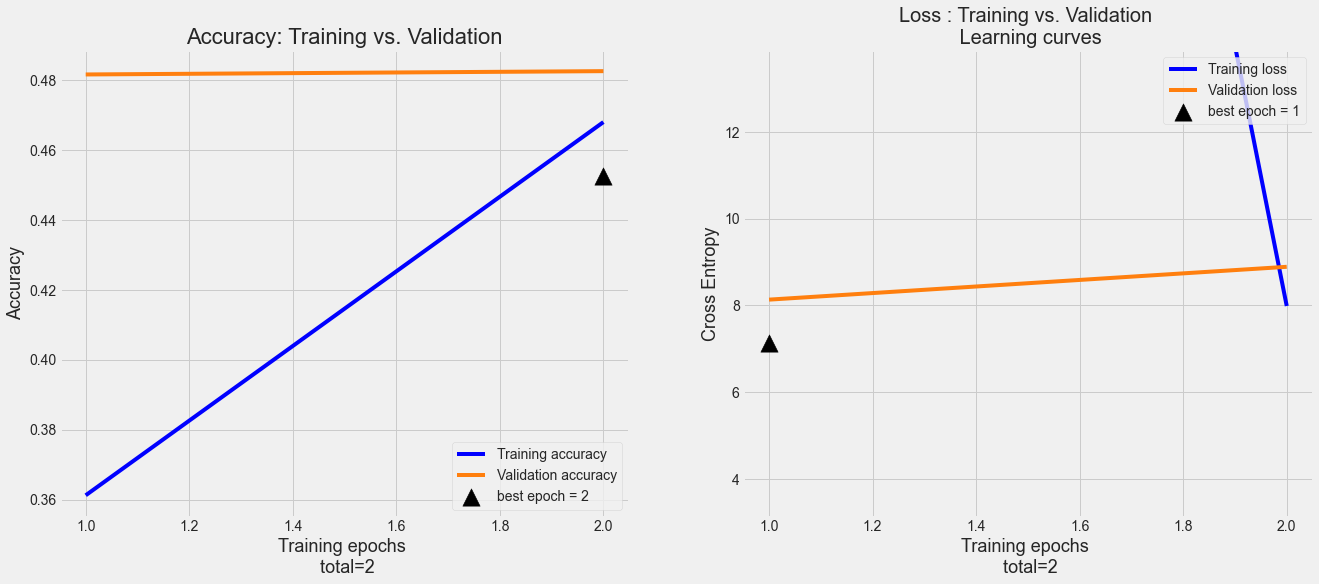

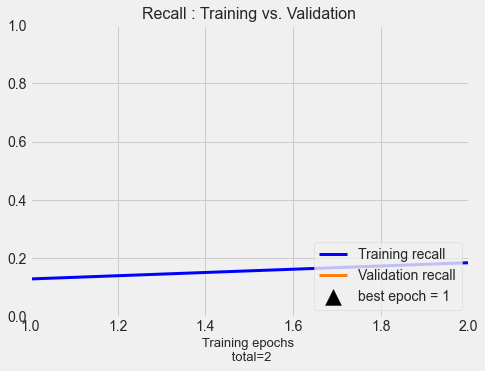

In [77]:
# Plot learning curves and Recall
plot_learning_curve_and_recall(history)

# 4) Choose Final Model

**Performance Metrics Comparison**

In [65]:
# Upload results from all models
baseline_results_df = pd.read_csv('Final_results/Baseline/baseline_results_df.csv', index_col='model')
untuned_results_df = pd.read_csv('Final_results/Basic/untuned_results_df.csv', index_col='model')
GS_results_df = pd.read_csv('Final_results/GS/GS_results_df.csv', index_col='model')
RS_results_df = pd.read_csv('Final_results/RS/RS_results_df.csv', index_col='model')
BS_results_df = pd.read_csv('Final_results/BS/BS_results_df.csv', index_col='model')


# ------------ Comparison 1: Performance metrics ------------
# Merge and save all results
print_in_color('\nPerformance metrics comparison between all models tested:',(0,255,255),(0,65,80))
results_df_SM = pd.concat([baseline_results_df, untuned_results_df, GS_results_df, RS_results_df, BS_results_df], axis=0) 
   
# Save merged results to a new file
results_df_SM.to_csv('Final_results/metrics_comparison_SM.csv', index_label='model')

# Display results   
results_df_SM2 = results_df_SM \
            .style.highlight_min(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='red', axis=0) \
            .highlight_max(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='green', axis=0) \
            .highlight_min(subset=['Loss_train','Loss_val'], color='green', axis=0) \
            .highlight_max(subset=['Loss_train','Loss_val'], color='red', axis=0) 
results_df_SM2


Performance metrics comparison between all models tested:



**Total Elasped Time Comparison**

In [66]:
# Elasped time comparison
baseline_tuned_SM = 927
pipeline_untuned_SM = 30
pipeline_kerasClassifier_GS_SM = 340
pipeline_kerasTuner_RS_SM = 89
pipeline_kerasTuner_BS_SM = 104

print_in_color('\n Total Pipeline duration comparison between all models tested: ',(0,255,255),(0,65,80))
print(f'''> BayesSearchCV Pipeline for Baseline: \t\t\t{baseline_tuned_SM:.0f} min
> Basic Untuned CNN model Pipeline: \t\t\t{pipeline_untuned_SM:.0f} min
> HalvingGridSearchCV Pipeline with Keras Wrapper: \t{pipeline_kerasClassifier_GS_SM:.0f} min
> RandomSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_RS_SM:.0f} min
> BayesSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_BS_SM:.0f} min
''')


 Total Pipeline duration comparison between all models tested: 

> BayesSearchCV Pipeline for Baseline: 			927 min
> Basic Untuned CNN model Pipeline: 			30 min
> HalvingGridSearchCV Pipeline with Keras Wrapper: 	340 min
> RandomSearch Pipeline using Keras-Tuner: 		89 min
> BayesSearch Pipeline using Keras-Tuner: 		104 min



# 5) Load Final Model and Weights

**(i) Load Final Model Structure**

In [76]:
model_loc_save = '/Sylvie_notebooks/DS4/Final_results/RS/best_tuned_RS_SM.h5'
final_model = tf.keras.models.load_model(model_loc_save)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 filters_conv_input (Conv2D)  (None, 100, 100, 96)     2496      
                                                                 
 norm_conv_input (BatchNorma  (None, 100, 100, 96)     384       
 lization)                                                       
                                                                 
 activation_conv_input (Acti  (None, 100, 100, 96)     0         
 vation)                                                         
                                                                 
 reducer_conv_input (MaxPool  (None, 50, 50, 96)       0         
 ing2D)                                                          
                                                                 
 filters_conv_2 (Conv2D)     (None, 50, 50, 128)       110720    
                                                      

**(ii) Load Final Model Best Weights** <br>
Saved from ModelCheckPoint callback

In [77]:
best_weights_name = 'RS_SM_best_weights-ep11-loss0.21.hdf5'
path_to_weights = os.path.join(path_to_cwd, 'Final_results/RS')
filepath = os.path.join(path_to_weights, best_weights_name)
final_model.load_weights(filepath)

# 6) Evaluate Final Model

## Test set pre-processing

In [78]:
# Label count
count = test_df['label'].value_counts(ascending=False)
print(count)
test_df.head()

Normal             1019
Lung_Opacity        602
COVID               362
Viral_Pneumonia     134
Name: label, dtype: int64


file_path            label
10726  /Sylvie_notebooks/DS4\Dataset/COVID\COVID-148.png            COVID
6189   /Sylvie_notebooks/DS4\Dataset/Normal\Normal-63...           Normal
11675  /Sylvie_notebooks/DS4\Dataset/COVID\COVID-2333...            COVID
11613  /Sylvie_notebooks/DS4\Dataset/COVID\COVID-2278...            COVID
19959  /Sylvie_notebooks/DS4\Dataset/Viral_Pneumonia\...  Viral_Pneumonia

**Use ImageDataGenerator to resize, rescale, and OHE the target for the test set**

In [79]:
df = test_df
image_col = 'file_path'
img_format = 'png'
batch_size = 32
test_generator = test_gen(df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) # Only rescale, resize, OHE

Found 2117 validated image filenames belonging to 4 classes.

val_generator:
 <class 'keras.preprocessing.image.DataFrameIterator'>

Number of images in the test_generator:

2117

List of classes in the test_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the test_generator:

[0, 2, 0, 0, 3, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0] 



**Plot sample of images from the test_generator**

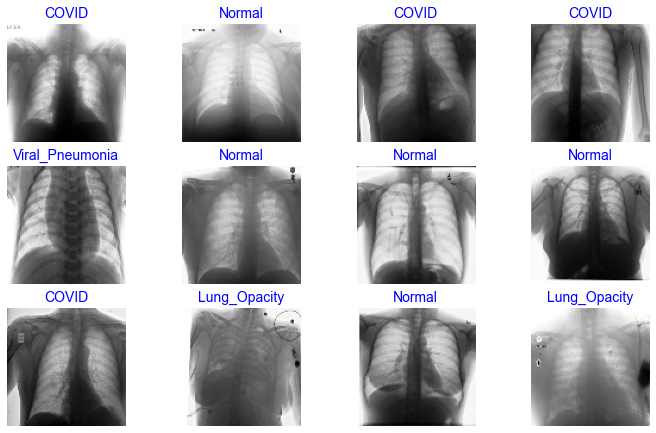

In [80]:
# Plot random images from the test_generator
generator = test_generator
n = 12
plot_size = (12,10)

# Call function 
image_samples_gen(generator, n, plot_size)

## Evaluation - Test set
Evaluate model on the test set to estimate the performance metrics and the Loss <br>
First, we need to compile the final model structure with its weights

In [81]:
metrics = ['accuracy', Recall(name='recall')]
loss = 'categorical_crossentropy'
final_model.compile(loss=loss, metrics=metrics)

In [82]:
step_size_test = test_generator.n//test_generator.batch_size
test_score_eval = final_model.evaluate_generator(test_generator, steps=step_size_test, verbose=1)

66/66 [==============================] - 13s 95ms/step - loss: 0.1953 - accuracy: 0.9238 - recall: 0.9219


In [83]:
final_test_loss_eval = test_score_eval[0]
final_test_acc_eval = test_score_eval[1]
final_test_rec_eval = test_score_eval[2]

print_in_color('\nPerformance Metrics: Final CNN Model', (0,255,255),(55,65,80))
print(f'''Test Accuracy: \t{final_test_acc_eval*100:.1f}%
Test Loss: \t{final_test_loss_eval:.2f}
Test Recall: \t{final_test_rec_eval:.2f}
''')


Performance Metrics: Final CNN Model

Test Accuracy: 	92.4%
Test Loss: 	0.20
Test Recall: 	0.92



## Predictions - Test set
Using the Model to Make Predictions <br>
Normally we would use new images with no labels to predict their Class. We can also include labels if they exist but
Keras will ignore them. 

Make predictions

In [84]:
test_generator.reset()
step_size_test = test_generator.n//test_generator.batch_size

preds = final_model.predict(test_generator, steps=step_size_test, verbose=1) # can also use model.predict_generator

66/66 [==============================] - 5s 74ms/step


Convert predictions to labels

In [85]:
# Predictions
y_pred = np.argmax(preds, axis=1)
# Convert value to class
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
pred_label = [labels[k] for k in y_pred]

Save predictions

In [86]:
# Convert to DF
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns={y_pred_df.columns[0]: 'pred'}, inplace=True)
y_true_df = pd.DataFrame(test_generator.classes)
y_true_df.rename(columns={y_true_df.columns[0]: 'true'}, inplace=True)

# Merge
pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

# Save predictions 
os.makedirs('predictions', exist_ok=True)  # create a leaf directory if not exist
pred_df.to_csv(path_or_buf='predictions/predictions.csv', index=False, header=True)  

### (i) Plot random predictions

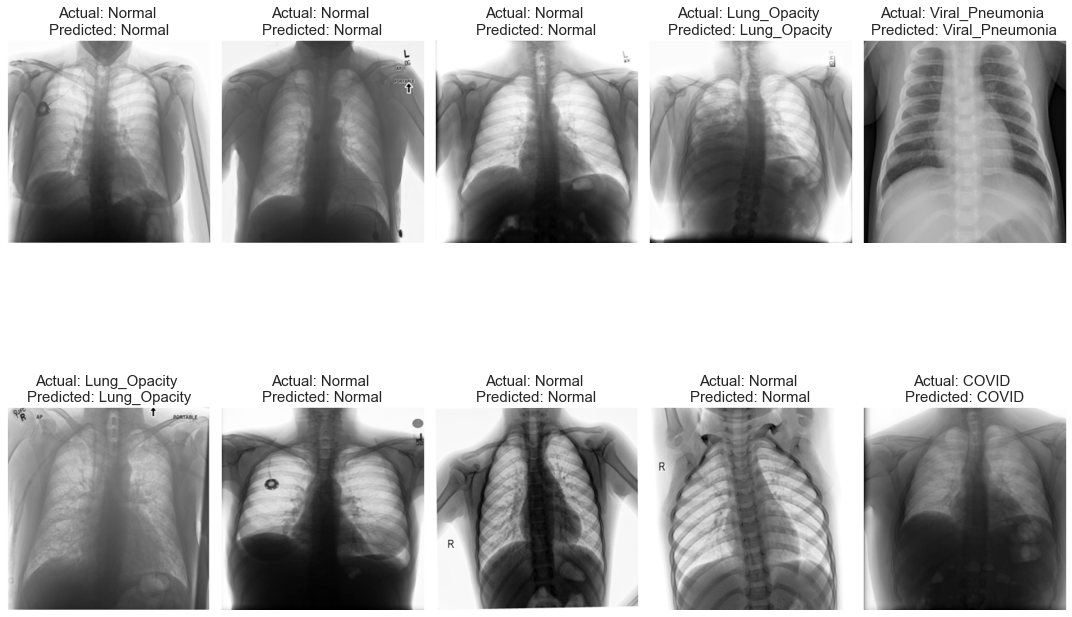

In [87]:
# Display samples Actual vs. Predicted from the test set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,12), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(test_df.shape[0])
    ax.imshow(plt.imread(test_df.file_path.iloc[idx]), cmap='Greys')
    ax.set_title(f"Actual: {test_df.label.iloc[idx].split()[0]} \nPredicted: {pred_label[idx].split()[0]}", fontsize=15)
plt.tight_layout();

### (ii) Single image prediction
Since we don't have new/unseen images by the model, we'll re-use the test set to make predictions on a random image in the test set.


This image below is predicted to be from the ['COVID'] Class



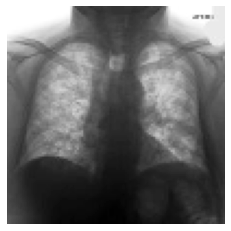

In [88]:
images, labels = test_generator.next() # one batch only
img_idx = np.random.randint(0,batch_size) # random image in the batch
new_img = images[img_idx]

# Predict
pred_img = final_model.predict(new_img.reshape(1, img_size[0], img_size[1], num_channels)) # reshape to 4D array so that it works with Keras

# Display prediction
y_pred = np.argmax(pred_img, axis=1)
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
pred_label = [labels[k] for k in y_pred]
msg = f'\nThis image below is predicted to be from the {pred_label} Class'
print_in_color(msg,(130,255,255), (55,65,80))

# Show image
plt.imshow(new_img, cmap='Greys')
plt.grid(None)
plt.axis('off');

## Confusion Matrix and Report


Examples of GOOD final model predictions with their probabilities:

          Filename                  Actual Class              Predicted Class         Probability   

   Lung_Opacity-1381.png            Lung_Opacity                Lung_Opacity               0.985    

   Lung_Opacity-1571.png            Lung_Opacity                Lung_Opacity               0.986    

      Normal-6622.png                  Normal                      Normal                  0.932    

      Normal-1596.png                  Normal                      Normal                  0.976    

   Lung_Opacity-3057.png            Lung_Opacity                Lung_Opacity               0.952    


Examples of final model prediction ERRORS with their probabilities:

          Filename                  Actual Class              Predicted Class         Probability   

    Lung_Opacity-762.png            Lung_Opacity                   Normal                  0.863    

      Normal-1665.png                  Normal

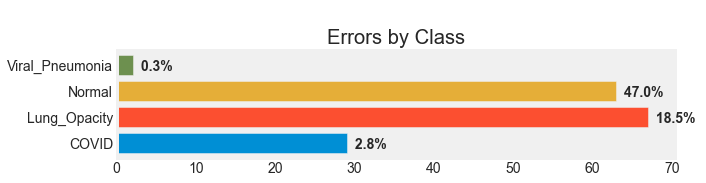

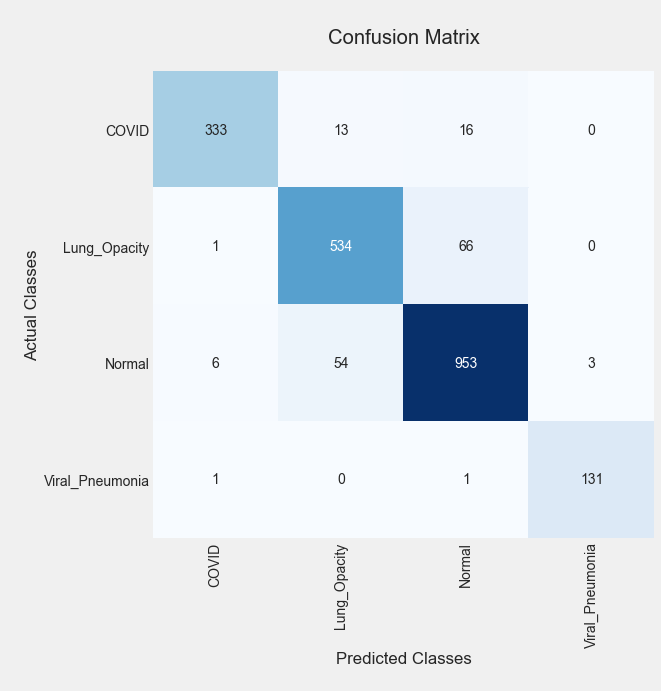

In [89]:
df_target = test_df.label
print_code = 5
model_name = 'Final Model (RS)'
final_test_acc, final_test_rec, _ = cm_and_report(test_generator, df_target, preds, print_code, model_name)

# 7) Generalization
Performance metrics summary for training, validation and test sets

In [102]:
# Only keep relevant column
best_model = 'RandomSearch (SM)'
df = results_df_SM.T
df = df[[best_model]].T

# Extract train, val, and test metric values from the model chosen to be the final_model
acc_train = df.at[best_model, 'Accuracy_train']
acc_val = df.at[best_model, 'Accuracy_val']
rec_train = df.at[best_model, 'Recall_train']
rec_val = df.at[best_model, 'Recall_val']
loss_train = df.at[best_model, 'Loss_train']
loss_val = df.at[best_model, 'Loss_val']
acc_test = final_test_acc_eval
rec_test = final_test_rec_eval
loss_test = final_test_loss_eval

# Create dictionnary
data = [{'Accuracy': acc_test*100, 'Recall': rec_test, 'Loss': loss_test},
        {'Accuracy': acc_val*100, 'Recall': rec_val, 'Loss': loss_val},
        {'Accuracy': acc_train*100, 'Recall': rec_train, 'Loss':loss_train}]
  
# Create DF
final_results = pd.DataFrame(data, index =['Test','Validation','Train'],
                                 columns =['Accuracy', 'Recall', 'Loss'])

final_results2 = final_results \
                .style.highlight_min(subset=['Accuracy','Recall'], color='red', axis=0) \
                .highlight_max(subset=['Accuracy', 'Recall'], color='green', axis=0) \
                .highlight_min(subset=['Loss'], color='green', axis=0) \
                .highlight_max(subset=['Loss'], color='red', axis=0) 

print_in_color('\n Generalization of the Final Model: ',(0,255,255), (0,65,80))
final_results2


 Generalization of the Final Model: 



# Save on Google Cloud Storage

In [104]:
# %%script False
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'

# Get GCS bucket with the key
storage_client = storage.Client.from_service_account_json(json_key_path)
bucket_name = 'big_data_project_storage'
bucket = storage_client.get_bucket(bucket_name)

# Convert local files as blobs (file name to be used in the bucket)
blob = bucket.blob('DS4_CNN_SM.ipynb')

# Upload to GCP (local file to be uploaded)
blob.upload_from_filename('DS4_CNN_SM.ipynb') 

In [ ]:
%%script False
!nvidia-smi

In [ ]:
%%script False
!tensorboard dev upload --logdir callbacks/logs/hparams

# Remove access
# !tensorboard dev auth revoke

# TensorBoard - Projector

In [93]:
# Load model
model_loc_save = '/Sylvie_notebooks/DS4/Final_results/RS/best_tuned_RS_SM.h5'
final_model = tf.keras.models.load_model(model_loc_save)

# Load weights
best_weights_name = 'RS_SM_best_weights-ep11-loss0.21.hdf5'
path_to_weights = os.path.join(path_to_cwd, 'Final_results/RS')
filepath = os.path.join(path_to_weights, best_weights_name)
final_model.load_weights(filepath)

# Compile
metrics = ['accuracy', Recall(name='recall')]
loss = 'categorical_crossentropy'
final_model.compile(loss=loss, metrics=metrics)

In [95]:
# Step 1: Create a second model that has the same input as the original but produces a low-dim representation
# Use the output layer before applying the activatin function (should be the lowest-dim layer)
embedder = tf.keras.models.Model(inputs=final_model.inputs, outputs=final_model.layers[-6].output) 

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 2: Convert images to tensor
def img_to_tensor(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)  # convert the compressed string to uint8 grayscale tensor
    img = tf.image.resize_with_pad(img,100,100)    # resize the tensor image (100,100,1)
    return img

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 3: Generate embeddings
images_pil = []      # list of 500 PIL images
images_embeddings = []  # list of arrays of TensorShape([500,64])
labels_list = []       # list of 500 shuffled string labels

for img_path in tqdm(train_df_balanced.file_path[:2500]):
    img_pil = PIL.Image.open(img_path).resize((100,100)) # create an actual image
    images_pil.append(img_pil)  #  create a list of PIL images to use for sprite
    
    img_tensor = img_to_tensor(img_path)    # create tensor images of shape=(100,100,1)
    img_embedding = embedder(tf.expand_dims(input=img_tensor, axis=0))  # add batch=1 dimension for a tensor image of shape=(1,64)
    images_embeddings.append(img_embedding.numpy()[0])

for label in train_df_balanced.label[:2500]:
    labels_list.append(label)

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 4: Output feature vectors
embeddings_dir = 'callbacks/logs/embeddings'
os.makedirs(embeddings_dir, exist_ok=True) # Make new directory if not exists

vectors_path = os.path.join(embeddings_dir, 'feature_vectors.tsv')
# vectors_path = os.path.join(embeddings_dir, 'feature_vectors.txt')
with open(vectors_path, 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(images_embeddings) # save on disk feature vectors (embeddings) shape=(100,64)

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 5: Output metadata to link images with their labels
metadata_path = os.path.join(embeddings_dir, 'metadata.tsv')
with open(metadata_path, 'w') as metadata_file:
    for label in labels_list:
        metadata_file.write(f'{label}\n')
metadata_file.close()
    
# ------------------------------------------------------------------------------------------------------------------------------------
# Step 6: Generate a sprite of our images so that TB can visualize them individually attending to their embeddings
one_square_size = int(np.ceil(np.sqrt(len(images_embeddings))))
master_width = 100*one_square_size
master_height = 100*one_square_size
spriteImage = PIL.Image.new(mode='RGBA', size=(master_width, master_height), color=(0,0,0,0)) # fully transparent  

for count, image in enumerate(images_pil):
    div, mod = divmod(count, one_square_size) 
    h_loc = 100*div
    w_loc = 100*mod
    spriteImage.paste(image, (w_loc, h_loc))
    
spriteImage.convert('L').save(f'{embeddings_dir}/spriteImage.png', transparency=0) # grayscale

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 7: Store the embeddings in tf Variable
feature_vectors = pd.read_csv(vectors_path, delimiter='\t', header=None)
embedding_var = tf.Variable(feature_vectors)   # array TensorShape([100, 64])
print('feature_vectors/embedding_var shape:', embedding_var.shape)
print('number of images:', embedding_var.shape[0])
print('size of feature vector for each image:', embedding_var.shape[1])

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 8: Create a checkpoint from embeddings
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(embeddings_dir, 'embedding.ckpt'))

# ------------------------------------------------------------------------------------------------------------------------------------
# Step 9: Setup configuration
from tensorboard.plugins import projector
config = projector.ProjectorConfig()

embedding = config.embeddings.add() # add multiple embeddings below
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv' # link tensor to labels
# embedding.metadata_path = metadata_path # link tensor to labels
embedding.sprite.image_path = 'spriteImage.png' # link tensor to sprite image
embedding.sprite.single_image_dim.extend([100,100]) 

projector.visualize_embeddings(embeddings_dir, config) # stores a config file used by the embedding projector


  0%|          | 0/2500 [00:00<?, ?it/s]

feature_vectors/embedding_var shape: (2500, 128)
number of images: 2500
size of feature vector for each image: 128


'callbacks/logs/embeddings\\embedding.ckpt-1'

In [97]:
# %%script False
!taskkill /IM "tensorboard.exe" /F # kill tensorboard port if open
!del /q %TMP%\.tensorboard-info\* # or remove folder manually at C:\Users\John\AppData\Local\Temp\.tensorboard-info

In [60]:
# Open tensorboard with on log data (images) we just saved
%tensorboard --logdir callbacks/logs/embeddings --port=6009

# TensorBoard - Dev

In [58]:
# Create a published TensorBoard.dev with all logs induded in the tensorboardDev folder
%tensorboard dev upload --logdir ./callbacks/tensorboardDev \
    --name "Final Model Experiment" \
    --description "Performance metrics for the Final CNN Model" \
    --one_shot # exit when finished

In [96]:
# list all experiments uploaded to https://tensorboard.dev
%tensorboard dev list

In [98]:
# Delete tensorboard.dev experiments
%tensorboard dev delete --experiment_id BZcqilfQTDKwd49XbYmIoA